## Import data
We start by importing python libraries and configuring jupyter.

In [75]:
# Initialization
%pylab inline
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.misc as spmisc

Populating the interactive namespace from numpy and matplotlib


/Users/elplatt/science3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Now we'll define helper functions to read data from either the original experiment or from oTree.

In [82]:
# Convert SDW2006 data to a data frame with a single count column
def sdw_to_world_song(df_raw):
    col_world_id = []
    col_song_id = []
    col_count = []
    song_ids = range(1,49)
    world_ids = range(1,10)
    # Get list of world ids present in df_raw
    world_ids = sorted(set(df_raw["world_id"]))
    for cur_world in world_ids:
        # Filter by world
        df_world = df_raw[df_raw["world_id"] == cur_world]
        for cur_song in song_ids:
            col_world_id.append(cur_world)
            col_song_id.append(cur_song)
            count = df_world["dl_{}".format(cur_song)].sum()
            col_count.append(count)
    df_downloads = pd.DataFrame({
        "world_id": col_world_id,
        "song_id": col_song_id,
        "download_count": col_count
    })
    return df_downloads

# Load oTree data into a data frame with the following columns:
#  - world_id
#  - song_id
#  - download_count
#  - mean_rating
def load_otree(data="data/cultural_market.csv", session=None):
    # Read csv in oTree format
    df_raw = pd.read_csv(data)
    # Remove all but desired session
    df_raw = df_raw[df_raw['session.code'] == session]
    # Generate list of songs and worlds
    row_count = int(list(df_raw["player.rows"])[0])
    col_count = int(list(df_raw["player.cols"])[0])
    num_songs = row_count * col_count
    song_ids = range(num_songs)
    world_ids = sorted(set(df_raw["player.world"]))
    # Count totals for each world/song combination
    col_world_id = []
    col_song_id = []
    col_download_count = []
    col_mean_rating = []
    for cur_world in world_ids:
        df_world = df_raw[df_raw["player.world"] == cur_world]
        for cur_song in song_ids:
            # Record song and world id
            col_world_id.append(cur_world)
            col_song_id.append(cur_song)
            # Count the number of downloads
            col_download_count.append(df_world["player.download_{}".format(cur_song)].sum())
            # Find the average rating
            rating_label = "player.rating_{}".format(cur_song)
            df_ratings = df_world[df_world[rating_label] > 0]
            col_mean_rating.append(df_ratings[rating_label].mean())
    df_downloads = pd.DataFrame({
        "world_id": col_world_id,
        "song_id": col_song_id,
        "download_count": col_download_count,
        "mean_rating": col_mean_rating
    })
    return df_downloads

def load_sdw(path):
    # Load data from all worlds in SDW experiment 1
    downloads_file = "{path}/musiclab_data/dynamics_downloads_download_w{world}_v{experiment}.txt"
    song_ids = range(1,49)
    world_ids = range(1,10)
    columns = ['user_id', 'world_id'] \
        + ["dl_{i}".format(i=i) for i in song_ids] \
        + ['timestamp']
    df_raw = pd.concat([
        pd.read_csv(
            downloads_file.format(path=path, world=w, experiment=1),
            comment="%",
            header=None,
            names=columns
        )
        for w in world_ids])
    return sdw_to_world_song(df_raw)

### Read the data into a data frame
The next line will read in the data from the original Salganik, Dodds, and Watts experiment. If you instead want to analyze data from oTree, remove the `#` from the beginning of the second line and enter the path to the csv file downloaded from oTree and the oTree session id of your experiment.

In [83]:
df_downloads = load_sdw("external/CM")
#df_downloads = load_otree(data="data/cultural_market.csv", session="iddr7oao")
df_downloads.head()

,download_count,song_id,world_id
0,15,1,1
1,18,2,1
2,7,3,1
3,11,4,1
4,9,5,1


In [84]:
# Count downloads for each song
def count_song_downloads(df_downloads):
    # Create list of song_id values present in input
    song_ids = sorted(set(df_downloads["song_id"]))
    # Create DataFrame for songs
    df_songs = pd.DataFrame({"song_id":song_ids}) \
        .set_index("song_id")
    df_songs["total_counts"] = [
        df_downloads[df_downloads["song_id"] == cur_song]["download_count"].sum()
        for cur_song in df_songs.index]
    return df_songs

# Count downloads for each world
def count_world_downloads(df_downloads):
    # Create list of world_id values present in input
    world_ids = sorted(set(df_downloads["world_id"]))
    # Create DataFrame for worlds
    df_worlds = pd.DataFrame({"world_id":world_ids}) \
        .set_index("world_id")
    # Count downloads for each world
    df_worlds["total_counts"] = [
        df_downloads[df_downloads["world_id"] == cur_world]["download_count"].sum()
        for cur_world in df_worlds.index
    ]
    return df_worlds

Text(0,0.5,'Count frequency')

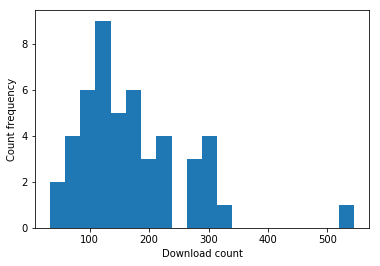

In [85]:
# Plot histogram of download counts
df_songs = count_song_downloads(df_downloads)
df_worlds = count_world_downloads(df_downloads)
plt.hist(df_songs["total_counts"], bins=20)
plt.xlabel("Download count")
plt.ylabel("Count frequency")

### Gini coefficient

In [86]:
def gini(x):
    '''Given a list of counts `x`, return the gini coefficient.'''
    n = len(x)
    gini_num = sum([sum([abs(x_i - x_j) for x_j in x]) for x_i in x])
    gini_den = 2.0 * n * sum([x_i for x_i in x])
    return gini_num / gini_den

def gini_bootstrap(x, samples=1000):
    '''Given a list of counts `x`, return gini estimate and (bootstrap) standard error.'''
#    x_all = [xi for xi in x if not np.isnan(xi)]
    x_all = list(x)
    n = len(x_all)
    num_estimates = []
    den_estimates = []
    for bootstrap_i in range(samples):
        bootstrap = [x_all[random.randint(0, len(x_all) - 1)] for x in x_all]
        gini_num = sum([sum([abs(x_i - x_j) for x_j in bootstrap]) for x_i in bootstrap])
        gini_den = 2.0 * (n - 1) * sum([x_i for x_i in bootstrap])
        num_estimates.append(gini_num)
        den_estimates.append(gini_den)
    num_mean_sq = sum([est**2 for est in num_estimates]) / len(num_estimates)
    num_mean = sum(num_estimates) / len(num_estimates)
    den_mean = sum(den_estimates) / len(den_estimates)
    num_var = num_mean_sq - (num_mean)**2
    gini = num_mean / den_mean
    gini_se = math.sqrt(num_var) / den_mean
    return gini, gini_se
    

In [87]:
def get_world_gini_evolution(world_id=9, experiment=1, smooth=0, samples=1000, step=1):
    '''Get the gini in one world over the course of the experiment.'''
    # Load the download file
    downloads_file = "external/CM/musiclab_data/dynamics_downloads_download_w{world}_v{experiment}.txt"
    song_ids = range(1,49)
    columns = ['user_id', 'world_id'] \
        + ["dl_{i}".format(i=i) for i in song_ids] \
        + ['timestamp']
    df_raw = pd.read_csv(
        downloads_file.format(world=world_id, experiment=experiment),
        comment="%",
        header=None,
        names=columns
    )
    # Sort downloads by time
    df_raw.sort_values("timestamp").head()

    # Loop through each participant and find gini
    gini_at_time = []
    gini_at_time_se = []
    smoothed_at_time = []
    counts = dict((song_id, 0) for song_id in song_ids)
    total_downloads = 0
    smoothed = 0
    for i in range(0, len(df_raw)):
        for song_id in song_ids:
            c = df_raw['dl_{}'.format(song_id)][i]
            total_downloads += c
            counts[song_id] += c
        if step > 1 and i % step != 0:
            continue
        g, se = gini_bootstrap(counts.values(), samples)
        if smooth > 1:
            previous = gini_at_time[-1*smooth:]
            smoothed = (g + sum(previous)) / (len(previous) + 1)
        else:
            smoothed = g
        gini_at_time.append(g)
        gini_at_time_se.append(se)
        smoothed_at_time.append(smoothed)
    return smoothed_at_time, gini_at_time_se

In [93]:
def plot_se(y, se, label="", color="#7f7fff"):
    x = range(len(y))
    y_low = np.array(y) - np.array(se)
    y_high = np.array(y) + np.array(se)
    plt.fill_between(x, y_low, y_high, color=(color+"4f"))
    plt.plot(x, y, label=label, color=color)


In [89]:
gini_t_19, gini_se_t_19 = get_world_gini_evolution(9, 1, smooth=10, samples=300, step=1)

In [ ]:
gini_t_14, gini_se_t_14 = get_world_gini_evolution(4, 1, smooth=10, samples=300, step=1)

In [96]:
gini_t_29, gini_se_t_29 = get_world_gini_evolution(9, 2, smooth=10, samples=300, step=1)

In [97]:
gini_t_24, gini_se_t_24 = get_world_gini_evolution(4, 2, smooth=10, samples=300, step=1)

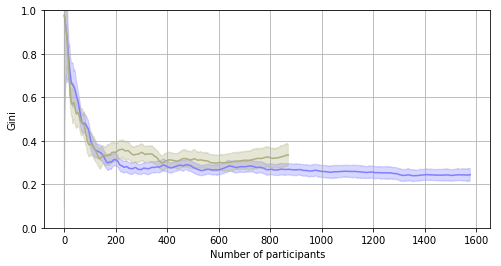

In [95]:
plt.figure(figsize=(8, 4))
plot_se(gini_t_19, gini_se_t_19)
plot_se(gini_t_14, gini_se_t_14, color="#afaf7f")
plt.ylim([0, 1])
plt.grid()
plt.xlabel("Number of participants")
plt.ylabel("Gini")
plt.legend()

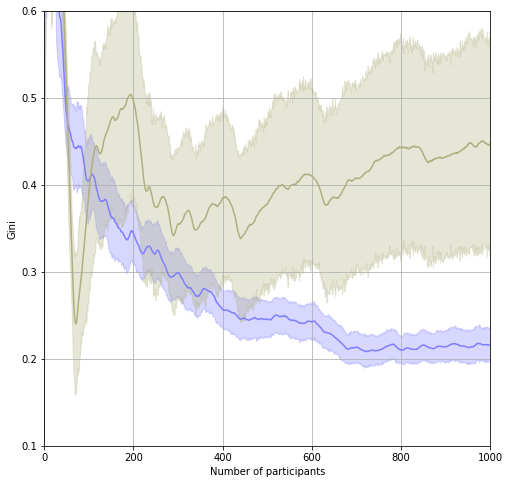

In [101]:
plt.figure(figsize=(8, 8))
plot_se(gini_t_29, gini_se_t_29)
plot_se(gini_t_24, gini_se_t_24, color="#afaf7f")
plt.ylim([0.1, 0.6]); plt.xlim([0, 1000])
plt.grid()
plt.xlabel("Number of participants")
plt.ylabel("Gini")
plt.legend()

## Power Analysis
Now that you've reproduced the analysis from (SDW2006), it's your turn! You will be running your own online experiment to measure the effects of social influence. But before starting an experiment, it's important to think about how much data you will need to collect in order to find what you're looking for. This is called power analysis.

As we saw above, the experimental results have some uncertainty. Rather than giving an exact gini coefficient, the experiment gives us a best guess and a range of likely values. With more and more data, the range becomes smaller, and the result becomes more certain. To figure out how much data your experiment will need, you can use the (SDW2006) data as a guide. The goal is to tell whether the gini coefficient of the social influence world is different from that of the control world. In other words, whether there is any overlap between the likely values for the two different conditions.

The figure below shows the evolution of the gini index (with confidence intervals) as new participants are added, for both the social and control groups. The left panel is for Experiment 1 (grid layout) while the right panel is for Experiment 2 (list layout).